In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import ast
from itertools import combinations
from itertools import chain

In [3]:
df = pd.read_csv('cleaned_ages_dataset.csv')
df.head()

,Name,Gender,Occupation,Birth year,Death year,Manner of death,Age of death,Associated Countries,Associated Country Life Expectancy,AOD_Category
0,douglas adams,['male'],['artist'],1952,2001,natural causes,49,['united kingdom'],[81.3],41-50
1,abraham lincoln,['male'],['politician'],1809,1865,homicide,56,['united states'],[78.5],51-60
2,paul morand,['male'],['artist'],1888,1976,NaN,88,['france'],[82.5],81-90
3,claude monet,['male'],['artist'],1840,1926,natural causes,86,['france'],[82.5],81-90
4,elvis presley,['male'],['artist'],1935,1977,natural causes,42,['united states'],[78.5],41-50


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621380 entries, 0 to 621379
Data columns (total 10 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Name                                621380 non-null  object
 1   Gender                              621380 non-null  object
 2   Occupation                          621380 non-null  object
 3   Birth year                          621380 non-null  int64 
 4   Death year                          621380 non-null  int64 
 5   Manner of death                     41868 non-null   object
 6   Age of death                        621380 non-null  int64 
 7   Associated Countries                621380 non-null  object
 8   Associated Country Life Expectancy  621178 non-null  object
 9   AOD_Category                        621380 non-null  object
dtypes: int64(3), object(7)
memory usage: 47.4+ MB


### Data Preprocessing

The data must be converted into a format that can be used for the Apriori algorithm. This means converting each item in the dataset into a 'transaction'. Each transaction is a set of attribute values, we use six columns for this: 'Gender', 'Occupation', 'Manner of death', 'Age of death', 'AOD_Category', and 'Associated Countries'.

an example of a transaction:<br>
{’AOD_Category=41-50’,’Age of death=49’,’Associated Countries=united kingdom’,’Gender=male’,’Manner of death=natural causes’,’Occupation=artist’}


In [5]:
# Remove rows with null values in 'Associated Countries' and 'Gender' columns
df_with_mod = df.dropna(subset=['Associated Countries', 'Gender', 'Occupation'])
df_without_mod = df_with_mod.copy()
df_without_mod.drop('Manner of death', axis=1, inplace=True)
selected_columns = ['Gender', 'Occupation', 'Age of death', 'AOD_Category', 'Associated Countries']

# Initialize an empty list to hold the transactions
transactions = []

# Convert each row in the dataset to a transaction
for index, row in df_without_mod.iterrows():
    transaction = []
    for col in selected_columns:
        # Special handling for 'Associated Countries' and 'Gender' columns which may have multiple values
        if col == 'Associated Countries' or col == 'Gender' or col == 'Occupation':
            # Convert the string representation to a list
            values = ast.literal_eval(row[col]) if isinstance(row[col], str) else row[col]
            for value in values:
                item = f"{col}={value}"
                transaction.append(item)
        else:
            # Create an item by combining the column name and the value (e.g., "Gender=male")
            item = f"{col}={row[col]}"
            transaction.append(item)
    transactions.append(set(transaction))

# Show the first 5 final revised transactions
transactions[:5]


[{'AOD_Category=41-50',
  'Age of death=49',
  'Associated Countries=united kingdom',
  'Gender=male',
  'Occupation=artist'},
 {'AOD_Category=51-60',
  'Age of death=56',
  'Associated Countries=united states',
  'Gender=male',
  'Occupation=politician'},
 {'AOD_Category=81-90',
  'Age of death=88',
  'Associated Countries=france',
  'Gender=male',
  'Occupation=artist'},
 {'AOD_Category=81-90',
  'Age of death=86',
  'Associated Countries=france',
  'Gender=male',
  'Occupation=artist'},
 {'AOD_Category=41-50',
  'Age of death=42',
  'Associated Countries=united states',
  'Gender=male',
  'Occupation=artist'}]

In [6]:
# Sample code to print out transactions with multiple 'Associated Countries' and 'Gender'
multigendertransactions = [transaction for transaction in transactions 
                            if  len([item for item in transaction if 'Occupation=' in item]) > 1]

multigendertransactions[:2]


[{'AOD_Category=41-50',
  'Age of death=44',
  'Associated Countries=france',
  'Gender=male',
  'Occupation=french resistance fighter',
  'Occupation=official'},
 {'AOD_Category=61-70',
  'Age of death=62',
  'Associated Countries=united states',
  'Gender=male',
  'Occupation=game designer',
  'Occupation=role-playing game designer'}]

### Item Frequency

In [7]:

# Calculate the frequency of each item across all transactions
item_frequency = defaultdict(int)

# Iterate through each transaction and count the occurrence of each item
for transaction in transactions:
    for item in transaction:
        item_frequency[item] += 1

# Sort items by frequency
sorted_items = sorted(item_frequency.items(), key=lambda x: x[1], reverse=True)

# Show some of the most frequent items
sorted_items[:10]


[('Gender=male', 554966),
 ('Occupation=artist', 180230),
 ('AOD_Category=71-80', 167739),
 ('AOD_Category=81-90', 150438),
 ('Associated Countries=united states', 142649),
 ('Occupation=politician', 121811),
 ('AOD_Category=61-70', 120545),
 ('Occupation=athlete', 89928),
 ('Associated Countries=united kingdom', 72835),
 ('Associated Countries=germany', 70178)]

### Generate Candidate Itemsets


In [8]:
def calculate_support_no_optimisations(itemset, transactions):
    itemset_count = 0
    total_transactions = len(transactions)
    for transaction in transactions:
        if itemset.issubset(transaction):
            itemset_count += 1
    support = itemset_count / total_transactions
    return support


def generate_candidates__no_optimisations(prev_frequent_itemsets):
    new_candidates = set()
    for i in prev_frequent_itemsets:
        for j in prev_frequent_itemsets:
            union_set = i.union(j)
            if len(union_set) == len(i) + 1:
                new_candidates.add(union_set)
    return new_candidates


def apriori_no_optimisations(transactions, min_support=0.1):
    frequent_itemsets = []
    
    # Generate initial candidates (1-itemsets)
    initial_candidates = set()
    for transaction in transactions:
        for item in transaction:
            initial_candidates.add(frozenset([item]))
            
    # Find frequent 1-itemsets
    frequent_1_itemsets = set()
    for itemset in initial_candidates:
        if calculate_support_no_optimisations(itemset, transactions) >= min_support:
            frequent_1_itemsets.add(itemset)
    frequent_itemsets.extend(frequent_1_itemsets)
    
    prev_frequent_itemsets = frequent_1_itemsets
    
    # Generate new candidates without pruning
    while len(prev_frequent_itemsets) > 0:
        new_candidates = generate_candidates__no_optimisations(prev_frequent_itemsets)
        new_frequent_itemsets = set()
        for itemset in new_candidates:
            if calculate_support_no_optimisations(itemset, transactions) >= min_support:
                new_frequent_itemsets.add(itemset)
        frequent_itemsets.extend(new_frequent_itemsets)
        prev_frequent_itemsets = new_frequent_itemsets
        
    return frequent_itemsets

min_support = 0.1
min_hash_count = 2  # Minimum count for hash table
subset_transactions = transactions[:10000]  # Adjust the subset size as needed
frequent_itemsets = apriori_no_optimisations(subset_transactions, min_support)
frequent_itemsets[:10]


[frozenset({'AOD_Category=71-80'}),
 frozenset({'AOD_Category=81-90'}),
 frozenset({'Occupation=artist'}),
 frozenset({'Gender=female'}),
 frozenset({'AOD_Category=51-60'}),
 frozenset({'Associated Countries=austria'}),
 frozenset({'Occupation=researcher'}),
 frozenset({'Associated Countries=united states'}),
 frozenset({'Occupation=politician'}),
 frozenset({'Gender=male'})]

### Optimizations to the Apriori Algorithm

The original Apriori was slow for big datasets. I implemented these four improvements:

1. **Early Pruning**: I cut down the list of possible item sets early on. This means fewer item sets to check later.
   
2. **Transaction Reduction**: I removed data rows that were already fully explained by frequent item sets. This makes the data smaller and faster to scan.

3. **Hash Method**: I used a hash table to keep track of item sets. This is faster than using lists or sets.

4. **Twice-Only Partitioning**: I split the data into smaller parts and ran Apriori on each. The results were then used for a final check on the full data. This means fewer item sets to check in the end.

These changes did not make any noticeable difference to the efficiency of the algorithm. This was baffling until I discovered  using the library apriori functions did not yield any association rules.

#### Why Optimisations Dont Help

**Low Support**: If the support for all multi-item itemsets in the dataset is below the minimum threshold the algorithm will spend a lot of time generating and checking itemsets that end up being discarded, which will render most optomisations ineffective.

**Sparse Data**: If the data is sparse, meaning there are few recurring patterns of items appearing together, then most of the candidate itemsets would be infrequent, leading to a large number of checks but not a lot of pruning or transaction reductions.

**Lack of Redundant Transactions**: If the dataset doesn't have many redundant transactions, then the transaction reduction step would not help much.

**Ineffective Pruning**: If the data is such that very few itemsets can be pruned early, the pruning step becomes almost useless, leading to a full scan of the dataset for each candidate set.

**Highly Varied Data**: If the data has high variance in terms of the items in transactions, then the hash-based technique and transaction reduction would not provide much benefit.

**Lack of Strong Associations**: Finally, the absence of association rules suggests that the data doesn't have strong associations between items. In this case, the algorithm has to go through the complete search space without finding anything substantial, making optimizations less effective.


In [9]:
# Simple hash function using ascii values of the first letter of each item
def simple_hash(itemset):
    return sum(ord(item[0]) for item in itemset)

def calculate_support(itemset, transactions):
    itemset_count = 0
    total_transactions = len(transactions)
    for transaction in transactions:
        if itemset.issubset(transaction):
            itemset_count += 1
    support = itemset_count / total_transactions
    return support


def generate_and_prune_candidates(prev_frequent_itemsets, min_hash_count=2):
    new_candidates = set()
    hash_table = {}
    
    # Generate candidate itemsets
    for i in prev_frequent_itemsets:
        for j in prev_frequent_itemsets:
            union_set = i.union(j)
            if len(union_set) == len(i) + 1:
                new_candidates.add(union_set)
                
                # Apply hash function
                hash_value = simple_hash(union_set)
                
                # Update hash table
                if hash_value in hash_table:
                    hash_table[hash_value] += 1
                else:
                    hash_table[hash_value] = 1
    
    # Prune candidates using hash table
    pruned_candidates = set()
    for itemset in new_candidates:
        hash_value = simple_hash(itemset)
        if hash_table.get(hash_value, 0) >= min_hash_count:
            pruned_candidates.add(itemset)
            
    return pruned_candidates

def remove_redundant_transactions(transactions, frequent_itemsets):
    # Initialize an empty list to hold the new transactions after removal
    new_transactions = []
    
    # Loop through each transaction in the list of transactions
    for transaction in transactions:
        is_redundant = True  # Assume the transaction is redundant until proven otherwise
        
        # Loop through each item in the transaction
        for item in transaction:
            # Check if this item is part of any frequent itemset
            is_item_in_frequent_itemset = False
            for frequent_itemset in frequent_itemsets:
                if frozenset([item]).issubset(frequent_itemset):
                    is_item_in_frequent_itemset = True
                    break
            
            # If the item is not in any frequent itemset, then the transaction is not redundant
            if not is_item_in_frequent_itemset:
                is_redundant = False
                break
        
        # If the transaction is not redundant, add it to the new list of transactions
        if not is_redundant:
            new_transactions.append(transaction)
            
    return new_transactions


def apriori_with_hashing(transactions, min_support=0.1, min_hash_count=2):
    frequent_itemsets = []
    
    # Generate initial candidates (1-itemsets)
    initial_candidates = set()
    for transaction in transactions:
        for item in transaction:
            initial_candidates.add(frozenset([item]))
            
    # Find frequent 1-itemsets
    frequent_1_itemsets = set()
    for itemset in initial_candidates:
        if calculate_support(itemset, transactions) >= min_support:
            frequent_1_itemsets.add(itemset)
    frequent_itemsets.extend(frequent_1_itemsets)
    
    prev_frequent_itemsets = frequent_1_itemsets
    
    # Generate and prune new candidates
    while len(prev_frequent_itemsets) > 0:
        # Remove redundant transactions
        transactions = remove_redundant_transactions(transactions, prev_frequent_itemsets)
        # Generate and prune candidates using hash-based technique
        new_candidates = generate_and_prune_candidates(prev_frequent_itemsets, min_hash_count)
        new_frequent_itemsets = set()
        for itemset in new_candidates:
            if calculate_support(itemset, transactions) >= min_support:
                new_frequent_itemsets.add(itemset)
        frequent_itemsets.extend(new_frequent_itemsets)
        prev_frequent_itemsets = new_frequent_itemsets
        
    return frequent_itemsets


def apriori_with_twice_only_partitioning(transactions, min_support=0.1):
    # Automatically calculate the partition size to evenly divide the dataset
    num_partitions = 10  # You can change this number as needed
    partition_size = len(transactions) // num_partitions
    
    # Create partitions
    partitions = [transactions[i:i + partition_size] for i in range(0, len(transactions), partition_size)]
    
    local_frequent_itemsets = set()
    for partition in partitions:
        local_frequent = apriori_with_hashing(partition, min_support)
        local_frequent_itemsets.update(local_frequent)
    
    global_frequent_itemsets = set()
    for itemset in local_frequent_itemsets:
        if calculate_support(itemset, transactions) >= min_support:
            global_frequent_itemsets.add(itemset)
            
    return global_frequent_itemsets
# Using a subset for testing purposes due to computational intensity
min_support = 0.1
min_hash_count = 2  # Minimum count for hash table
subset_transactions = transactions[:200000]  # Adjust the subset size as needed
frequent_itemsets = apriori_with_hashing(subset_transactions, min_support, min_hash_count)

# Show some frequent itemsets
frequent_itemsets[:30]

[frozenset({'AOD_Category=71-80'}),
 frozenset({'AOD_Category=81-90'}),
 frozenset({'Occupation=artist'}),
 frozenset({'AOD_Category=51-60'}),
 frozenset({'Occupation=athlete'}),
 frozenset({'Occupation=researcher'}),
 frozenset({'Associated Countries=united states'}),
 frozenset({'Occupation=politician'}),
 frozenset({'Gender=male'}),
 frozenset({'AOD_Category=61-70'}),
 frozenset({'Associated Countries=germany'}),
 frozenset({'Gender=male', 'Occupation=researcher'}),
 frozenset({'Associated Countries=united states', 'Gender=male'}),
 frozenset({'Gender=male', 'Occupation=politician'}),
 frozenset({'AOD_Category=61-70', 'Gender=male'}),
 frozenset({'Associated Countries=germany', 'Gender=male'}),
 frozenset({'Gender=male', 'Occupation=artist'}),
 frozenset({'AOD_Category=71-80', 'Gender=male'}),
 frozenset({'AOD_Category=81-90', 'Gender=male'}),
 frozenset({'AOD_Category=51-60', 'Gender=male'})]

### Verifying the Algorithm

The apriori algorithm which has been developed must be demonstrated to work correctly.<br>
Therefore a small dataset with known association rules will be used for verification.

In [10]:
# Sample transaction list for Apriori
verification_transactions = [
    {'AOD_Category=41-50', 'Age of death=49', 'Associated Countries=united kingdom', 'Gender=male', 'Occupation=artist'},
    {'AOD_Category=41-50', 'Age of death=45', 'Associated Countries=united kingdom', 'Gender=male', 'Occupation=artist'},
    {'AOD_Category=41-50', 'Age of death=48', 'Associated Countries=united kingdom', 'Gender=male', 'Occupation=artist'},
    {'AOD_Category=51-60', 'Age of death=56', 'Associated Countries=united states', 'Gender=male', 'Occupation=politician'},
    {'AOD_Category=51-60', 'Age of death=55', 'Associated Countries=united states', 'Gender=male', 'Occupation=politician'},
    {'AOD_Category=81-90', 'Age of death=88', 'Associated Countries=france', 'Gender=male', 'Occupation=artist'},
    {'AOD_Category=81-90', 'Age of death=89', 'Associated Countries=france', 'Gender=male', 'Occupation=artist'},
    {'AOD_Category=81-90', 'Age of death=86', 'Associated Countries=france', 'Gender=male', 'Occupation=artist'},
    {'AOD_Category=31-40', 'Age of death=35', 'Associated Countries=france', 'Gender=female', 'Occupation=scientist'},
    {'AOD_Category=31-40', 'Age of death=36', 'Associated Countries=france', 'Gender=female', 'Occupation=scientist'},
    {'AOD_Category=31-40', 'Age of death=37', 'Associated Countries=france', 'Gender=female', 'Occupation=scientist'}
]


verification_frequent_itemsets = apriori_no_optimisations(verification_transactions, min_support)
verification_frequent_itemsets_with_hashing = apriori_with_hashing(verification_transactions, min_support, min_hash_count)

# Compare the results for equality
print(verification_frequent_itemsets == verification_frequent_itemsets_with_hashing)
# Show some frequent itemsets
verification_frequent_itemsets_with_hashing[:15]

False


[frozenset({'AOD_Category=31-40'}),
 frozenset({'AOD_Category=81-90'}),
 frozenset({'AOD_Category=41-50'}),
 frozenset({'AOD_Category=51-60'}),
 frozenset({'Gender=female'}),
 frozenset({'Occupation=scientist'}),
 frozenset({'Associated Countries=united states'}),
 frozenset({'Associated Countries=france'}),
 frozenset({'Associated Countries=united kingdom'}),
 frozenset({'Occupation=politician'}),
 frozenset({'Gender=male'}),
 frozenset({'Occupation=artist'}),
 frozenset({'Associated Countries=united kingdom', 'Occupation=artist'}),
 frozenset({'AOD_Category=81-90', 'Associated Countries=france'}),
 frozenset({'Associated Countries=france', 'Occupation=scientist'})]

### Generating Association Rules

The frequent item sets have been found, now association rules for them must be found using these steps:

1. **Rule Formation**: For each frequent itemset \($ F $\), generate all non-empty subsets \($ A $\) of \($ F $\). 
   $$ A \subseteq F $$
   
2. **Confidence Calculation**: For each rule \($ A \Rightarrow F-A $\), calculate the confidence as follows:
   $$ \text{Confidence}(A \Rightarrow F-A) = \frac{\text{support}(F)}{\text{support}(A)} $$

3. **Rule Pruning**: Keep only those rules that meet a minimum confidence threshold.

#### Function Definitions:

- `calculate_confidence(A, B, frequent_itemsets, transactions)`: This function calculates the confidence of an association rule \($ A \Rightarrow B $\). It divides the support of both \($ A $\) and \($ B $\) (i.e., \($ A \cup B $\)) by the support of \($ A $\).
   $$ \text{Confidence}(A \Rightarrow B) = \frac{\text{support}(A \cup B)}{\text{support}(A)} $$

- `generate_association_rules(frequent_itemsets, transactions, min_confidence=0.7)`: This function generates the association rules from the frequent itemsets. It uses the `calculate_confidence` function to prune out rules that don't meet the minimum confidence threshold.



In [11]:
# Function to calculate confidence
def calculate_confidence(A, B, frequent_itemsets, transactions):
    support_A = calculate_support(A, transactions)
    support_AB = calculate_support(A.union(B), transactions)
    return support_AB / support_A if support_A > 0 else 0

# Function to generate association rules
def generate_association_rules(frequent_itemsets, transactions, min_confidence=0.7):
    rules = []
    for itemset in frequent_itemsets:
        if len(itemset) > 1:  # Skip 1-itemsets
            subsets = list(chain.from_iterable(combinations(itemset, i) for i in range(1, len(itemset))))
            for A in subsets:
                A = frozenset(A)
                B = itemset.difference(A)
                if len(A) > 0 and len(B) > 0:  # Skip empty sets
                    confidence = calculate_confidence(A, B, frequent_itemsets, transactions)
                    if confidence >= min_confidence:
                        rules.append((A, B, confidence))
    return rules

# Function to format a single rule into a readable string
def format_rule(rule):
    antecedent = ', '.join(list(rule[0]))
    consequent = ', '.join(list(rule[1]))
    confidence = rule[2]
    return f"{antecedent} => {consequent} (Confidence: {confidence:.2f})"

# Function to print all association rules in a readable format
def print_all_rules(rules):
    for rule in rules:
        readable_rule = format_rule(rule)
        print(readable_rule)

min_confidence = 0.4
association_rules = generate_association_rules(frequent_itemsets, subset_transactions, min_confidence)
print_all_rules(association_rules)


Occupation=researcher => Gender=male (Confidence: 0.95)
Associated Countries=united states => Gender=male (Confidence: 0.89)
Occupation=politician => Gender=male (Confidence: 0.96)
AOD_Category=61-70 => Gender=male (Confidence: 0.93)
Associated Countries=germany => Gender=male (Confidence: 0.92)
Occupation=artist => Gender=male (Confidence: 0.84)
AOD_Category=71-80 => Gender=male (Confidence: 0.92)
AOD_Category=81-90 => Gender=male (Confidence: 0.90)
AOD_Category=51-60 => Gender=male (Confidence: 0.92)


In [12]:
verification_association_rules = generate_association_rules(verification_frequent_itemsets, verification_transactions, min_confidence)
print_all_rules(verification_association_rules)

Occupation=artist => Associated Countries=united kingdom (Confidence: 0.50)
Associated Countries=united kingdom => Occupation=artist (Confidence: 1.00)
AOD_Category=81-90 => Associated Countries=france (Confidence: 1.00)
Associated Countries=france => AOD_Category=81-90 (Confidence: 0.50)
Occupation=scientist => Associated Countries=france (Confidence: 1.00)
Associated Countries=france => Occupation=scientist (Confidence: 0.50)
Associated Countries=united states => Gender=male (Confidence: 1.00)
Associated Countries=france => Gender=male (Confidence: 0.50)
Associated Countries=united kingdom => Gender=male (Confidence: 1.00)
Occupation=artist => Associated Countries=france (Confidence: 0.50)
Associated Countries=france => Occupation=artist (Confidence: 0.50)
Occupation=politician => Gender=male (Confidence: 1.00)
Gender=female => Occupation=scientist (Confidence: 1.00)
Occupation=scientist => Gender=female (Confidence: 1.00)
Gender=female => Associated Countries=france (Confidence: 1.0

### Library Apriori Functions

Now external library implementations of apriori will be used to validate and compare results.<br>
Both `mlxtend` and `apyori` libraries offer implementations of the Apriori algorithm, but they differ in design and customization options.

#### 1. mlxtend

- **Two-Step Process**: First, find frequent itemsets using `apriori()` and then generate association rules with `association_rules()`.
- **Dataframe Input**: Accepts a DataFrame where each row represents a transaction and each column a unique item.
- **Metric Options**: Allows you to use several metrics including "lift", "confidence", and "zhangs_metric" to evaluate the quality of the rules.

  ```python
  frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
  rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)


In [13]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
# Transform list of transactions into an array format suitable for mlxtend
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

# Create a DataFrame
df = pd.DataFrame(te_array, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(AOD_Category=61-70),(Gender=male),0.193996,0.893119,0.178281,0.918993,1.028971,0.005020,1.319409,0.034932
1,(AOD_Category=71-80),(Gender=male),0.269946,0.893119,0.245085,0.907905,1.016555,0.003991,1.160551,0.022308
2,(AOD_Category=81-90),(Gender=male),0.242103,0.893119,0.211507,0.873622,0.978171,-0.004720,0.845731,-0.028603
3,(Associated Countries=germany),(Gender=male),0.112939,0.893119,0.103774,0.918849,1.028810,0.002906,1.317072,0.031568
4,(Associated Countries=united kingdom),(Gender=male),0.117215,0.893119,0.105551,0.900487,1.008251,0.000864,1.074050,0.009270


#### 2. apyori

- **Single-Step Process**: Generates both frequent itemsets and association rules in one function call.
- **List Input**: Takes a list of transactions as input, where each transaction is a list of items.
- **Confidence as Default Metric**: Only "confidence" is used as the metric with a minimum threshold.

  ```python
  results = list(apriori(transactions, min_support=0.1, min_confidence=0.7))


In [14]:
from apyori import apriori
# Run Apriori
results = list(apriori(transactions, min_support=0.1, min_confidence=0.7))

# Print out the results
for item in results:
    # Extract the itemset and support
    itemset = item[0]
    support = item[1]
    # Loop through the rules
    for rule in item[2]:
        antecedent = rule[0]
        consequent = rule[1]
        print(f"Rule: {antecedent} -> {consequent}")
        print(f"Support: {item[1]}")
        print(f"Confidence: {item[2][0].confidence}")
        print("Lift: " + str(item[2][0].lift))
        print("="*20)



Rule: frozenset() -> frozenset({'Gender=male'})
Support: 0.8931185425987318
Confidence: 0.8931185425987318
Lift: 1.0
Rule: frozenset({'AOD_Category=61-70'}) -> frozenset({'Gender=male'})
Support: 0.17828060124239595
Confidence: 0.9189929072130738
Lift: 1.0289708066513261
Rule: frozenset({'AOD_Category=71-80'}) -> frozenset({'Gender=male'})
Support: 0.24508513309086227
Confidence: 0.907904542175642
Lift: 1.0165554726183235
Rule: frozenset({'AOD_Category=81-90'}) -> frozenset({'Gender=male'})
Support: 0.21150664649650777
Confidence: 0.8736223560536567
Lift: 0.978170661994827
Rule: frozenset({'Associated Countries=germany'}) -> frozenset({'Gender=male'})
Support: 0.10377385818661689
Confidence: 0.9188492120037619
Lift: 1.0288099151207417
Rule: frozenset({'Associated Countries=united kingdom'}) -> frozenset({'Gender=male'})
Support: 0.10555054877852522
Confidence: 0.9004874030342556
Lift: 1.0082507081468517
Rule: frozenset({'Associated Countries=united states'}) -> frozenset({'Gender=male'

## ECLAT

### Transforming Data for ECLAT

The ECLAT algorithm requires the data to be structured in a particular way. Unlike Apriori, where each transaction is a set of items, in ECLAT we start with each item and keep track of all the transactions where that item appears. This is known as the TID (Transaction ID) set for each item. 

To transform the data to fit this model, we create a dictionary where the keys are the unique items in the transactions, and the values are sets of transaction IDs where each item appears. Here's a brief overview of the steps:

1. **Initialize a Dictionary**: Create an empty dictionary, `item_tid_map`, to store the TID sets for each item.
2. **Enumerate Transactions**: Loop through the list of transactions, keeping track of the transaction ID (index in the list).
3. **Populate Dictionary**: For each item in each transaction, add the transaction ID to the corresponding TID set in `item_tid_map`.

The result is a dictionary where each key-value pair represents an item and its corresponding TID set. This will be the input format for the ECLAT algorithm.

Here's a snippet of Python code that performs this transformation:

```python
from collections import defaultdict

def transform_to_eclat_format(transactions):
    item_tid_map = defaultdict(set)
    for tid, transaction in enumerate(transactions):
        for item in transaction:
            item_tid_map[item].add(tid)
    return item_tid_map


In [28]:
from collections import defaultdict

def transform_to_eclat_format(transactions):
    item_tid_map = defaultdict(set)
    for tid, transaction in enumerate(transactions):
        for item in transaction:
            item_tid_map[item].add(tid)
    return item_tid_map

ECLAT_dict = transform_to_eclat_format(transactions[:100000])
# Print out to check
# for index, (item, tid_set) in enumerate(ECLAT_dict.items()):
#     if index >= 10:
#         break
#     print(f"{item}: {tid_set}")



In [16]:
def eclat(prefix_itemset, remaining_items_tidsets, min_support, frequent_itemsets_list):
    # Loop through the remaining items and their Tidsets
    while remaining_items_tidsets:
        # Pop the first item and its Tidset
        current_item, current_tidset = remaining_items_tidsets.pop(0)
        
        # Calculate the support for the current item
        current_support = len(current_tidset)
        
        # Check if the current item meets the minimum support
        if current_support >= min_support:
            # If it does, add it to the list of frequent itemsets
            frequent_itemsets_list.append((prefix_itemset + [current_item], current_support))
            
            # Initialize a list to store new item-Tidset pairs
            new_items_tidsets = []
            
            # Loop through the remaining items and their Tidsets
            for next_item, next_tidset in remaining_items_tidsets:
                # Find the intersection between the current and next Tidsets
                intersected_tidset = next_tidset.intersection(current_tidset)
                
                # If the intersected set meets the minimum support, add it to the list of new item-Tidset pairs
                if len(intersected_tidset) >= min_support:
                    new_items_tidsets.append((next_item, intersected_tidset))
            
            # Sort the new items and Tidsets by the length of their Tidsets in descending order
            sorted_new_items_tidsets = []
            for item, tidset in new_items_tidsets:
                sorted_new_items_tidsets.append((item, tidset))
            sorted_new_items_tidsets.sort(key=lambda item: len(item[1]), reverse=True)
            
            # Recursively call the eclat function with the new prefix and remaining items
            eclat(prefix_itemset + [current_item], sorted_new_items_tidsets, min_support, frequent_itemsets_list)

# Initialize variables
minimum_support = 2  # Modify the minimum support as needed
frequent_itemsets_result = []

# Sort items by frequency and create the initial item-Tidset pairs
initial_item_tidset_pairs = sorted(ECLAT_dict.items(), key=lambda item: len(item[1]), reverse=True)

# Run the ECLAT algorithm
eclat([], initial_item_tidset_pairs, minimum_support, frequent_itemsets_result)

# Output the frequent itemsets
print(frequent_itemsets_result[:5])



[(['Gender=male'], 554966), (['Gender=male', 'AOD_Category=71-80'], 152291), (['Gender=male', 'AOD_Category=71-80', 'Occupation=artist'], 38934), (['Gender=male', 'AOD_Category=71-80', 'Occupation=artist', 'Associated Countries=united states'], 7587), (['Gender=male', 'AOD_Category=71-80', 'Occupation=artist', 'Associated Countries=united states', 'Age of death=75'], 805)]


### Reusability of Apriori Functions for ECLAT

The functions written for generating association rules in the Apriori algorithm are not directly reusable for ECLAT because of two reasons:

1. **Support Calculation**: In the Apriori algorithm, the `calculate_support` function is used to compute the support of an itemset every time a confidence value is needed. In ECLAT, the support values are precomputed and stored, so there's no need to recalculate them.

2. **Transaction Input**: The functions for Apriori take the full transaction dataset as input for support and confidence calculations. ECLAT works with a different data structure (in this case a set of transaction IDs), making it incompatible.


Due to these differences, it was necessary to:

1. Create a new `calculate_confidence_eclat` function that fetches precomputed support values from the ECLAT data structure.

2. Create a new `generate_association_rules_eclat` function to work specifically with the ECLAT's list of frequent itemsets and their corresponding support values.

In [17]:
# Function to calculate confidence
def calculate_confidence_eclat(A, F, frequent_itemsets_dict):
    support_A = frequent_itemsets_dict[frozenset(A)]
    support_F = frequent_itemsets_dict[frozenset(F)]
    return support_F / support_A if support_A > 0 else 0

# Function to generate association rules
def generate_association_rules_eclat(frequent_itemsets, min_confidence=0.7):
    rules = []
    frequent_itemsets_dict = {frozenset(itemset): support for itemset, support in frequent_itemsets}
    
    for itemset, support in frequent_itemsets:
        if len(itemset) > 1:
            itemset = set(itemset)  # Convert list to set if it's not a set already
            subsets = list(chain.from_iterable(combinations(itemset, i) for i in range(1, len(itemset))))
            for A in subsets:
                A = set(A)
                B = itemset.difference(A)
                confidence = calculate_confidence_eclat(A, itemset, frequent_itemsets_dict)
                if confidence >= min_confidence:
                    rules.append((A, B, confidence))
                    
    return rules

# Function to print the association rules clearly
def print_association_rules(rules, limit=None):
    if limit is not None:
        rules = rules[:limit]
        
    for antecedent, consequent, confidence in rules:
        print(f"Rule: {', '.join(antecedent)} -> {', '.join(consequent)}")
        print(f"Confidence: {confidence:.4f}")
        print("="*25)

min_confidence = 0.7
association_rules = generate_association_rules_eclat(frequent_itemsets_result, min_confidence)
print_association_rules(association_rules, limit=7)

Rule: AOD_Category=71-80 -> Gender=male
Confidence: 0.9079
Rule: Occupation=artist, AOD_Category=71-80 -> Gender=male
Confidence: 0.8214
Rule: Associated Countries=united states, Occupation=artist, AOD_Category=71-80 -> Gender=male
Confidence: 0.7671
Rule: Associated Countries=united states, Occupation=artist, Age of death=75 -> AOD_Category=71-80, Gender=male
Confidence: 0.7703
Rule: Associated Countries=united states, Occupation=artist, AOD_Category=71-80, Age of death=75 -> Gender=male
Confidence: 0.7703
Rule: Associated Countries=united states, Occupation=artist, Age of death=75, Gender=male -> AOD_Category=71-80
Confidence: 1.0000
Rule: Associated Countries=united states, Occupation=artist, Age of death=75, Associated Countries=united kingdom -> AOD_Category=71-80, Gender=male
Confidence: 0.8889


# Understanding `min_support` in ECLAT Implementations

In my original ECLAT implementation, I used an **absolute minimum support of 2**. This means that an itemset needs to be present in at least 2 transactions to be considered as a frequent itemset.

Contrastingly, the `pyECLAT` library expects the `min_support` parameter to be a fraction of the total number of transactions. To make the `min_support` in `pyECLAT` equivalent to the absolute support count of 2 in my own code, I used the following formula:

$$\text{min\_support} = \frac{2}{\text{len(transactions)}}$$

This ensures that the results are comparable between my custom implementation and the `pyECLAT` library.


In [29]:
from pyECLAT import ECLAT
from scipy.sparse import csr_matrix


def transform_dict_to_df(eclat_dict, num_transactions):
    df = pd.DataFrame(index=range(num_transactions))
    for item, tids in eclat_dict.items():
        df[item] = 0
        df.loc[tids, item] = 1
    df.fillna(0, inplace=True)
    return df

def transform_dict_to_sparse_df(eclat_dict, num_transactions):
    indptr = [0]
    indices = []
    data = []
    for tid_set in eclat_dict.values():
        for tid in tid_set:
            indices.append(tid)
            data.append(1)
        indptr.append(len(indices))
    
    sparse_matrix = csr_matrix((data, indices, indptr), dtype=int, shape=(len(eclat_dict), num_transactions))
    df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
    return df

# Print out the results
def print_results(combination, support, limit=None):
    if limit:
        combination, support = combination[:limit], support[:limit]
        
    for c, s in zip(combination, support):
        print(f"Combination: {c}, Support: {s}")
        print("="*25)

num_transactions = len(transactions[:100000])

eclat_df = transform_dict_to_sparse_df(ECLAT_dict, num_transactions)




In [30]:
eclat = ECLAT(data=eclat_df)
# eclat.df_bin

KeyboardInterrupt: 

In [ ]:
eclat.fit(min_support=2, verbose=True)

# Get the combination and support
combination, support = eclat.get_support()
print_results(combination, support, limit=7)

In [20]:
2/num_transactions

3.218642376645531e-06

## Time Series

In [ ]:
# Group by 'Birth year' and count the number of occurrences for each year
grouped_by_year_count = df['Birth year'].value_counts().sort_index().reset_index()
grouped_by_year_count.columns = ['Birth year', 'Count']

plt.figure(figsize=(12, 6))
plt.bar(grouped_by_year_count['Birth year'], grouped_by_year_count['Count'], color='blue')
plt.xlabel('Birth Year')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points for Each Birth Year')
plt.show()


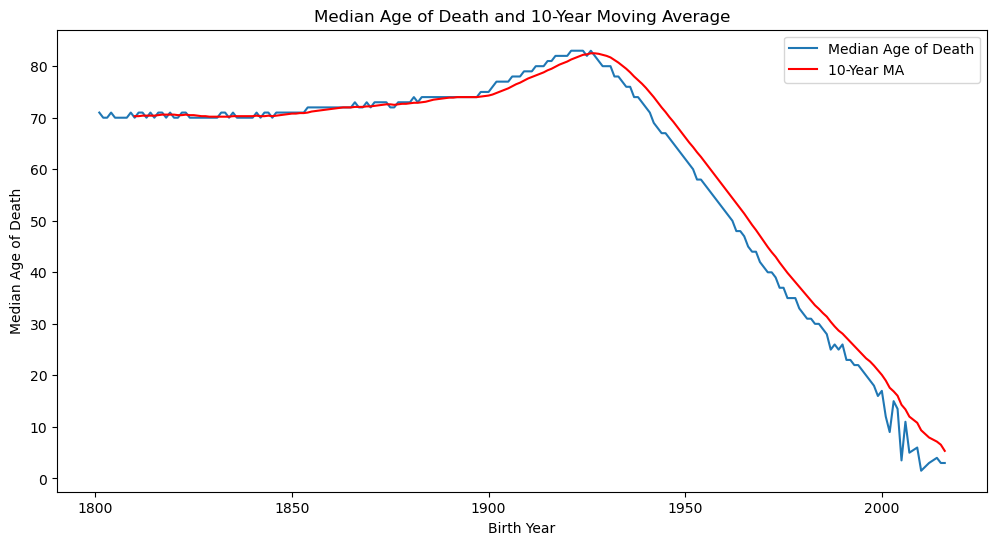

In [ ]:
# Group by 'Birth year' and calculate the median age of death for each group
grouped_by_year_median = df.groupby('Birth year')['Age of death'].median().reset_index()

# Calculate 10-year moving average of the median age of death
grouped_by_year_median['10-Year MA'] = grouped_by_year_median['Age of death'].rolling(window=10).mean()

# Plotting
plt.figure(figsize=(12, 6))

# Plot the actual median age of death
plt.plot(grouped_by_year_median['Birth year'], grouped_by_year_median['Age of death'], linestyle='-', label='Median Age of Death')

# Plot the 10-year moving average
plt.plot(grouped_by_year_median['Birth year'], grouped_by_year_median['10-Year MA'], marker='', linestyle='-', color='red', label='10-Year MA')

plt.xlabel('Birth Year')
plt.ylabel('Median Age of Death')
plt.title('Median Age of Death and 10-Year Moving Average')
plt.legend()
plt.show()


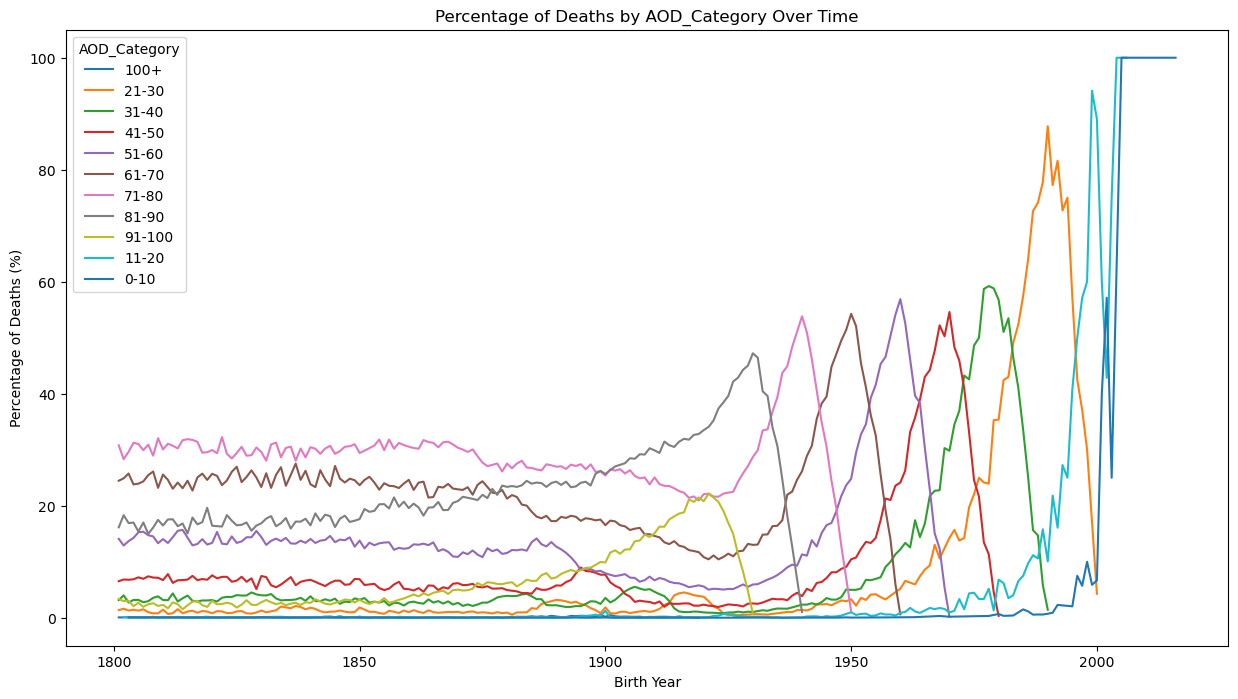

In [ ]:
# Group by 'Birth year' and 'AOD_Category', then count the number of occurrences for each group
grouped_by_year_category = df.groupby(['Birth year', 'AOD_Category']).size().reset_index(name='Count')

# Calculate the total number of deaths for each 'Birth year'
total_count_by_year = grouped_by_year_category.groupby('Birth year')['Count'].sum().reset_index(name='Total_Count')

# Merge the two DataFrames to calculate percentages
grouped_by_year_category = pd.merge(grouped_by_year_category, total_count_by_year, on='Birth year')

# Calculate the percentage of each category for each year
grouped_by_year_category['Percentage'] = (grouped_by_year_category['Count'] / grouped_by_year_category['Total_Count']) * 100

plt.figure(figsize=(15, 8))
for category in grouped_by_year_category['AOD_Category'].unique():
    subset = grouped_by_year_category[grouped_by_year_category['AOD_Category'] == category]
    plt.plot(subset['Birth year'], subset['Percentage'], marker='', label=category)

plt.xlabel('Birth Year')
plt.ylabel('Percentage of Deaths (%)')
plt.title('Percentage of Deaths by AOD_Category Over Time')
plt.legend(title='AOD_Category')
plt.show()


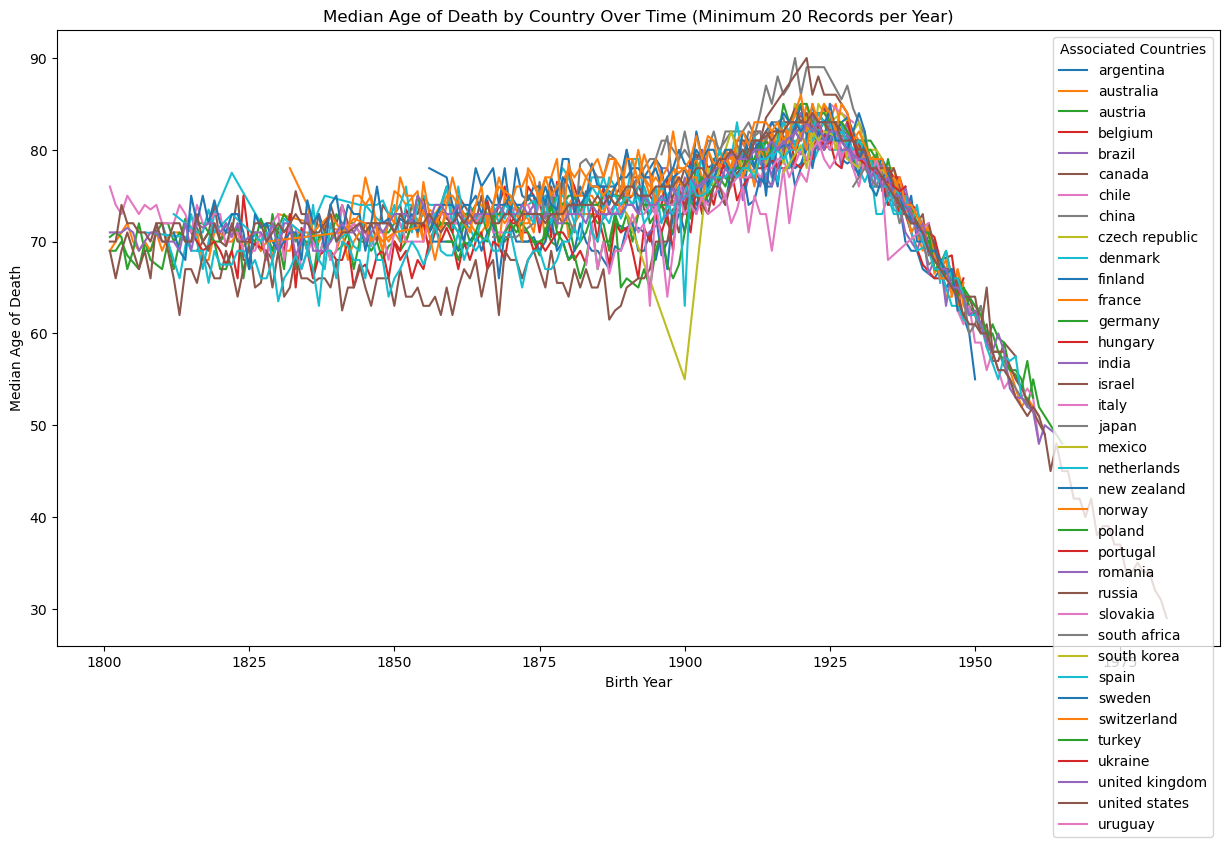

In [ ]:
df['Associated Countries'] = df['Associated Countries'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Explode the DataFrame so each row corresponds to only one country
df_exploded = df.explode('Associated Countries')

# Group by 'Associated Countries' and 'Birth year' and calculate the median age of death for each group
grouped_by_country_year = df_exploded.groupby(['Associated Countries', 'Birth year'])

# Filter groups with at least 20 records
filtered_grouped_by_country_year = grouped_by_country_year.filter(lambda x: len(x) >= 50)

# Calculate the median age of death for the filtered groups
filtered_grouped_by_country_year_median = filtered_grouped_by_country_year.groupby(['Associated Countries', 'Birth year'])['Age of death'].median().reset_index()

# Plotting
plt.figure(figsize=(15, 8))
for country in filtered_grouped_by_country_year_median['Associated Countries'].unique():
    subset = filtered_grouped_by_country_year_median[filtered_grouped_by_country_year_median['Associated Countries'] == country]
    plt.plot(subset['Birth year'], subset['Age of death'], marker='', label=country)

plt.xlabel('Birth Year')
plt.ylabel('Median Age of Death')
plt.title('Median Age of Death by Country Over Time (Minimum 20 Records per Year)')
plt.legend(title='Associated Countries')
plt.show()

